## Import & Define functions

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_validate
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot
from numpy import array
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
def getNullPercent( data ):
    data = (data.isnull().sum()/len( data )*100)
    data = pd.DataFrame(data.sort_values( ascending=False ) ) 
    data.columns = ["Percent"]     
    data = data[ data["Percent"] != 0  ]
    return data

In [116]:
def confusion_matrix_scorer(model, X, y):
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    return {'tn': cm[0, 0], 'fp': cm[0, 1],
            'fn': cm[1, 0], 'tp': cm[1, 1]}

In [51]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TPR = cm[0,0]/(cm[0,0]+cm[1,0])
    FPR = cm[0,1]/(cm[0,1]+cm[1,1])
    print('TP = ', cm[0,0])
    print('FP = ', cm[0,1])
    print('FN = ', cm[1,0])
    print('TN = ', cm[1,1])
    print("TPR = ", str(cm[0,0]/(cm[0,0]+cm[1,0])) )
    print("FPR = ", str(cm[0,1]/(cm[0,1]+cm[1,1])))

    return {'TP': cm[0, 0], 'FP': cm[0, 1],'FN': cm[1, 0], 'TN': cm[1, 1], 'TPR':TPR, 'FPR': FPR}

----

## Data Cleaning

In [4]:
df = pd.read_csv("in-vehicle-coupon-recommendation.csv")
df.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


In [5]:
getNullPercent( df )

,Percent
car,99.148534
CoffeeHouse,1.710817
Restaurant20To50,1.490066
CarryAway,1.190476
RestaurantLessThan20,1.024913
Bar,0.843582


In [6]:
df = df.drop(["car"], axis = 1)

In [7]:
df = df.dropna(axis = 0)

In [8]:
for i in df.columns:
    LE = LabelEncoder()
    df[i] = LE.fit_transform(df[i])
#df

In [22]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [23]:
X_train, X_test, y_train, y_test = train_test_split( X , y , test_size = 0.3, random_state = 100)

## Random Forest

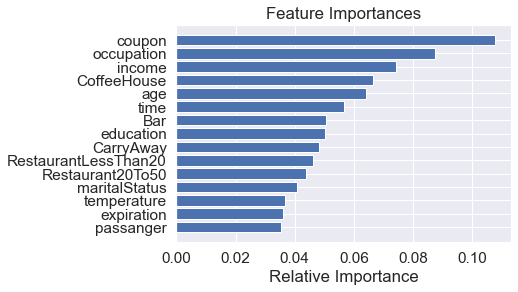

In [108]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[-15:]  
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [109]:
y_pred_test = forest.predict(X_test)
accuracy_score(y_test, y_pred_test)

0.7373068432671082

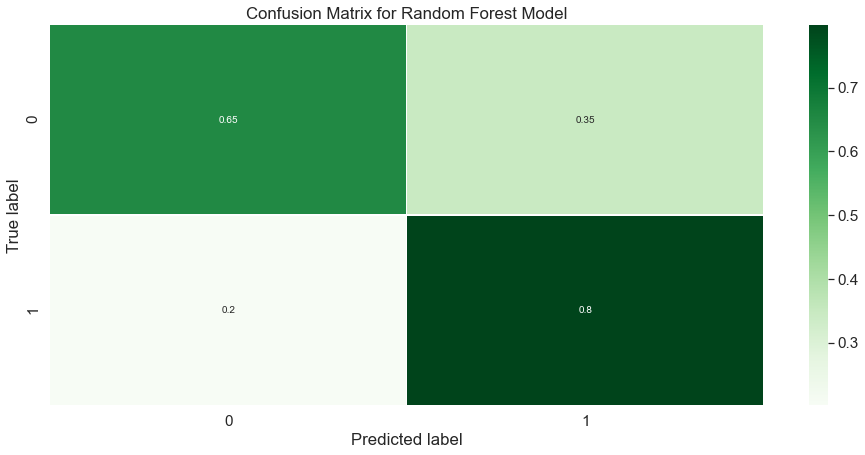

In [110]:
matrix = confusion_matrix(y_test, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)



plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [111]:
result_1 = model_selection.cross_val_score(forest, X_train, y_train, cv = 10, scoring='accuracy')
print('Accuracy -val set: %.2f%% (%.2f)' % (result_1.mean()*100, result_1.std()))
result_1

Accuracy -val set: 74.41% (0.01)


array([0.74586288, 0.75886525, 0.73758865, 0.75650118, 0.72222222,
       0.73964497, 0.75384615, 0.73964497, 0.74201183, 0.7443787 ])

In [117]:
cv_results_1 = cross_validate(forest, X_train, y_train, cv = 10, scoring = confusion_matrix_scorer)
cv_results_1

{'fit_time': array([0.48992085, 0.48892021, 0.48891973, 0.48841953, 0.48591781,
        0.48841953, 0.48741889, 0.48741889, 0.48591757, 0.48691797]),
 'score_time': array([0.02101755, 0.02151847, 0.02151847, 0.02201915, 0.02151871,
        0.02101851, 0.02101851, 0.02151847, 0.02151871, 0.02151895]),
 'test_tn': array([244, 246, 246, 245, 237, 227, 233, 242, 221, 239]),
 'test_fp': array([124, 122, 122, 123, 131, 141, 134, 125, 146, 128]),
 'test_fn': array([100,  84,  88,  93,  97,  82,  86,  87,  89,  81]),
 'test_tp': array([378, 394, 390, 385, 381, 395, 392, 391, 389, 397])}

In [118]:
df_re_1 = pd.DataFrame(data = result_1, columns = ["Accuracy"])
df_re_1

,Accuracy
0,0.745863
1,0.758865
2,0.737589
3,0.756501
4,0.722222
5,0.739645
6,0.753846
7,0.739645
8,0.742012
9,0.744379


In [119]:
df_cre_1 = pd.DataFrame(data = cv_results_1)
df_cre_1

,fit_time,score_time,test_tn,test_fp,test_fn,test_tp
0,0.489921,0.021018,244,124,100,378
1,0.488920,0.021518,246,122,84,394
2,0.488920,0.021518,246,122,88,390
3,0.488420,0.022019,245,123,93,385
4,0.485918,0.021519,237,131,97,381
5,0.488420,0.021019,227,141,82,395
6,0.487419,0.021019,233,134,86,392
7,0.487419,0.021518,242,125,87,391
8,0.485918,0.021519,221,146,89,389
9,0.486918,0.021519,239,128,81,397


In [120]:
df_1 = df_re_1.join(df_cre_1, how='outer')
df_1["TPR"] = df_1["test_tp"] / (df_1["test_tp"] + df_1["test_fn"])
df_1["FPR"] = df_1["test_fp"] / (df_1["test_fp"] + df_1["test_tn"])
df_1 = df_1.drop(['fit_time', 'score_time'], axis=1)

In [121]:
df_1.rename(columns={'test_tn': 'TN', 'test_fp': 'FP', 'test_fn': 'FN', 'test_tp': 'TP'}, inplace=True)

In [122]:
df_1.T

,0,1,2,3,4,5,6,7,8,9
Accuracy,0.745863,0.758865,0.737589,0.756501,0.722222,0.739645,0.753846,0.739645,0.742012,0.744379
TN,244.000000,246.000000,246.000000,245.000000,237.000000,227.000000,233.000000,242.000000,221.000000,239.000000
FP,124.000000,122.000000,122.000000,123.000000,131.000000,141.000000,134.000000,125.000000,146.000000,128.000000
FN,100.000000,84.000000,88.000000,93.000000,97.000000,82.000000,86.000000,87.000000,89.000000,81.000000
TP,378.000000,394.000000,390.000000,385.000000,381.000000,395.000000,392.000000,391.000000,389.000000,397.000000
TPR,0.790795,0.824268,0.815900,0.805439,0.797071,0.828092,0.820084,0.817992,0.813808,0.830544
FPR,0.336957,0.331522,0.331522,0.334239,0.355978,0.383152,0.365123,0.340599,0.397820,0.348774


## Support Vector Machine

In [99]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)
accuracy_score(y_test, y_pred_test)

0.6269315673289183

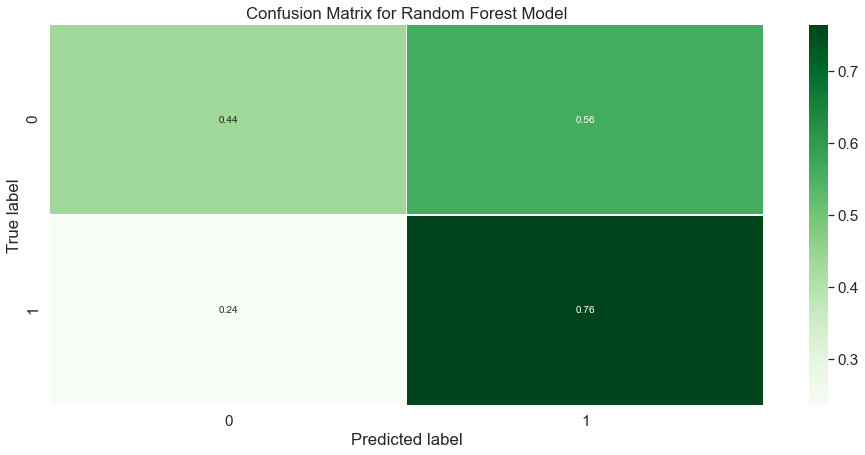

In [100]:
matrix = confusion_matrix(y_test, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)



plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [101]:
result_2 = model_selection.cross_val_score(clf, X_train, y_train, cv = 10, scoring='accuracy')
print('Accuracy -val set: %.2f%% (%.2f)' % (result_2.mean()*100, result_2.std()))
result_2

Accuracy -val set: 62.93% (0.01)


array([0.62056738, 0.62293144, 0.63238771, 0.63947991, 0.62411348,
       0.62721893, 0.61065089, 0.63313609, 0.6260355 , 0.65680473])

In [102]:
cv_results_2 = cross_validate(clf, X_train, y_train, cv = 10, scoring = confusion_matrix_scorer)
cv_results_2

{'fit_time': array([2.79239941, 2.80891371, 2.73485017, 2.70532441, 2.85695481,
        2.70732665, 2.7728827 , 2.65528226, 2.85945749, 2.74686027]),
 'score_time': array([0.09458137, 0.09508157, 0.09458113, 0.09758401, 0.10308838,
        0.09558225, 0.0945816 , 0.09458089, 0.09458113, 0.09508181]),
 'test_tn': array([165, 163, 151, 167, 161, 162, 168, 167, 159, 174]),
 'test_fp': array([203, 205, 217, 201, 207, 206, 199, 200, 208, 193]),
 'test_fn': array([118, 114,  94, 104, 111, 109, 130, 110, 108,  97]),
 'test_tp': array([360, 364, 384, 374, 367, 368, 348, 368, 370, 381])}

In [103]:
df_re_2 = pd.DataFrame(data = result_2, columns = ["Accuracy"])
df_cre_2 = pd.DataFrame(data = cv_results_2)
df_2 = df_re_2.join(df_cre_2, how='outer')
df_2["TPR"] = df_2["test_tp"] / (df_2["test_tp"] + df_2["test_fn"])
df_2["FPR"] = df_2["test_fp"] / (df_2["test_fp"] + df_2["test_tn"])
df_2 = df_2.drop(['fit_time', 'score_time'], axis=1)
df_2.rename(columns={'test_tn': 'TN', 'test_fp': 'FP', 'test_fn': 'FN', 'test_tp': 'TP'}, inplace=True)

In [104]:
df_2.T

,0,1,2,3,4,5,6,7,8,9
Accuracy,0.620567,0.622931,0.632388,0.639480,0.624113,0.627219,0.610651,0.633136,0.626036,0.656805
TN,165.000000,163.000000,151.000000,167.000000,161.000000,162.000000,168.000000,167.000000,159.000000,174.000000
FP,203.000000,205.000000,217.000000,201.000000,207.000000,206.000000,199.000000,200.000000,208.000000,193.000000
FN,118.000000,114.000000,94.000000,104.000000,111.000000,109.000000,130.000000,110.000000,108.000000,97.000000
TP,360.000000,364.000000,384.000000,374.000000,367.000000,368.000000,348.000000,368.000000,370.000000,381.000000
TPR,0.753138,0.761506,0.803347,0.782427,0.767782,0.771488,0.728033,0.769874,0.774059,0.797071
FPR,0.551630,0.557065,0.589674,0.546196,0.562500,0.559783,0.542234,0.544959,0.566757,0.525886


## LSTM

In [85]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from keras.layers import Embedding
import numpy as np

fold_no = 1
kfold = KFold(n_splits = 10, shuffle=True)
acc_per_fold = []
loss_per_fold = []
Confusion_matrix = []

for train, test in kfold.split(X_train, y_train):

  # Define the model architecture
    Seq_model = Sequential()
    Seq_model.add(Embedding(20, output_dim=256))
    Seq_model.add(LSTM(128))
    Seq_model.add(Dense(64, activation = 'relu'))
    Seq_model.add(Dense(1, activation = 'sigmoid'))

  # Compile the model
    Seq_model.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics = ['accuracy'])


  # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

  # Fit data to model
    history = Seq_model.fit(X_train, y_train, batch_size = 10, epochs = 150, verbose = 0)
  # Generate generalization metrics
    scores = Seq_model.evaluate(X_test, y_test, verbose=0)
    print(f'Score for fold {fold_no}: {Seq_model.metrics_names[0]} of {scores[0]}; {Seq_model.metrics_names[1]} of {scores[1]*100}%')

    print(Seq_model.evaluate(X_train, y_train))
    
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    y_pred = (Seq_model.predict(X_train) > 0.7).astype("int32")
    print_confusion_matrix(y_train, y_pred)

    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 1.979650616645813; accuracy of 70.03311514854431%
265/265 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 0.9965
[0.01106316689401865, 0.9964517951011658]
TP =  3665
FP =  11
FN =  19
TN =  4760
TPR =  0.994842562432139
FPR =  0.002305596311045902
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 1.7867531776428223; accuracy of 70.1434850692749%
265/265 [==============================] - 1s 2ms/step - loss: 0.0272 - accuracy: 0.9914
[0.02720322273671627, 0.9913660287857056]
TP =  3660
FP =  16
FN =  70
TN =  4709
TPR =  0.9812332439678284
FPR =  0.0033862433862433864
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 2.146106719970703; accuracy of 70.0055181980133%
265/265 [=======================

In [125]:
result_3 = sum(acc_per_fold) / len(acc_per_fold)
result_3

69.82339918613434

## Conclution

In [105]:
final = [result_1.mean()*100, result_2.mean()*100, result_3]

In [123]:
final

[74.32270202973967, 62.93326059283505, 69.82339918613434]

In [106]:
print("Here is the table of accuracy for three algorithms\n"
      + "Random Forest: " + str(round(result_1.mean()*100,2)) +"%\n"
      + "SVM: " + str(round(result_2.mean()*100,2)) +"%\n"
      + "LSTM: " + str(round(result_3,2)) +"%\n\n"
      + "Hence, the best model is Random Forest with " +  str(round(result_1.mean()*100,2))+ "% of accuracy" )

Here is the table of accuracy for three algorithms
Random Forest: 74.32%
SVM: 62.93%
LSTM: 69.82%

Hence, the best model is Random Forest with 74.32% of accuracy
